In [1]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.1 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import optuna

from google.colab import drive
drive.mount('/content/drive')
# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/Teddy.csv')


# Define feature columns and target column (using normalized features)
features = ['feat1', 'feat2', 'feat3', 'feat4', 'feat5']
target = 'z_spec'

# Handle missing values
df = df.dropna(subset=features + [target])

X = df[features]
y = df[target]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



Mounted at /content/drive


In [3]:
# Define the objective function for Optuna
def objective(trial):
    model_type = trial.suggest_categorical('model_type', ['RandomForest', 'GradientBoosting'])
    if model_type == 'RandomForest':
        n_estimators = trial.suggest_int('n_estimators', 50, 300)
        max_depth = trial.suggest_int('max_depth', 10, 50)
        model = RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            random_state=42
        )
    else:
        learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.2)
        n_estimators = trial.suggest_int('n_estimators', 50, 300)
        max_depth = trial.suggest_int('max_depth', 10, 50)
        model = GradientBoostingRegressor(
            learning_rate=learning_rate,
            n_estimators=n_estimators,
            max_depth=max_depth,
            random_state=42
        )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    return mse

In [4]:
# Create a study and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

# Get the best hyperparameters
best_params = study.best_params
print(f'Best hyperparameters: {best_params}')

# Train and evaluate the best model
if best_params['model_type'] == 'RandomForest':
    best_model = RandomForestRegressor(
        n_estimators=best_params['n_estimators'],
        max_depth=best_params['max_depth'],
        random_state=42
    )
else:
    best_model = GradientBoostingRegressor(
        learning_rate=best_params['learning_rate'],
        n_estimators=best_params['n_estimators'],
        max_depth=best_params['max_depth'],
        random_state=42
    )

best_model.fit(X_train, y_train)
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
r2_train = best_model.score(X_train, y_train)

mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
r2_test = best_model.score(X_test, y_test)

print(f'Training MSE: {mse_train}')
print(f'Training RMSE: {rmse_train}')
print(f'Training R²: {r2_train}')
print(f'Test MSE: {mse_test}')
print(f'Test RMSE: {rmse_test}')
print(f'Test R²: {r2_test}')

[I 2024-08-02 10:57:23,819] A new study created in memory with name: no-name-46178b69-b997-4ed6-a7a7-7091e1290f94
<ipython-input-3-d6b3b85edc73>:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.2)
[I 2024-08-02 11:16:42,182] Trial 0 finished with value: 0.0023782401004250678 and parameters: {'model_type': 'GradientBoosting', 'learning_rate': 0.16022653659564212, 'n_estimators': 146, 'max_depth': 28}. Best is trial 0 with value: 0.0023782401004250678.
[I 2024-08-02 11:20:33,768] Trial 1 finished with value: 0.0016429993543804213 and parameters: {'model_type': 'RandomForest', 'n_estimators': 73, 'max_depth': 22}. Best is trial 1 with value: 0.0016429993543804213.
<ipython-input-3-d6b3b85edc73>:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. Th

Best hyperparameters: {'model_type': 'RandomForest', 'n_estimators': 286, 'max_depth': 17}
Training MSE: 0.0007822957573493596
Training RMSE: 0.02796955053892285
Training R²: 0.9561739546613334
Test MSE: 0.001610145203865892
Test RMSE: 0.0401266146574302
Test R²: 0.9096095201492962


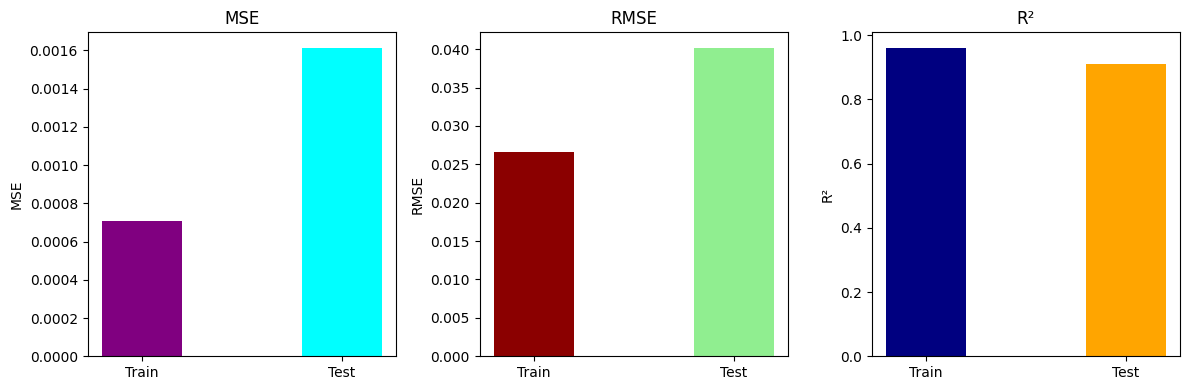

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# New performance metrics
training_scores = [0.0007063669932992196, 0.026577565601447015, 0.960427662321778]
test_scores = [0.0016141123620710361, 0.0401760172499843, 0.9093868114563499]

# Set the figure size
plt.figure(figsize=(12, 4))

# Plotting MSE
plt.subplot(1, 3, 1)
bar_width = 0.4
index = np.arange(2)
plt.bar(index, [training_scores[0], test_scores[0]], bar_width, color=['purple', 'cyan'])
plt.xticks(index, ['Train', 'Test'])
plt.title('MSE')
plt.ylabel('MSE')

# Plotting RMSE
plt.subplot(1, 3, 2)
plt.bar(index, [training_scores[1], test_scores[1]], bar_width, color=['darkred', 'lightgreen'])
plt.xticks(index, ['Train', 'Test'])
plt.title('RMSE')
plt.ylabel('RMSE')

# Plotting R²
plt.subplot(1, 3, 3)
plt.bar(index, [training_scores[2], test_scores[2]], bar_width, color=['navy', 'orange'])
plt.xticks(index, ['Train', 'Test'])
plt.title('R²')
plt.ylabel('R²')

plt.tight_layout()
plt.show()


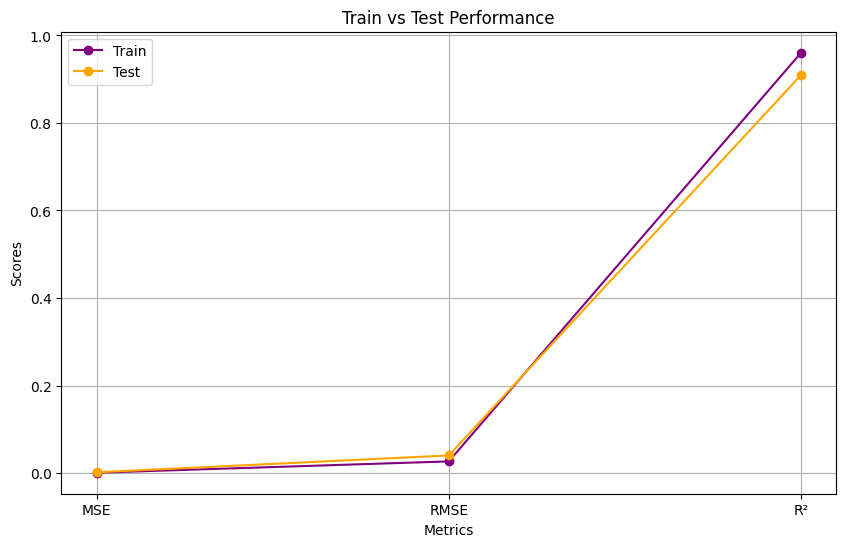

In [6]:
# Data for plotting
metrics = ['MSE', 'RMSE', 'R²']
train_scores = [0.0007063669932992196, 0.026577565601447015, 0.960427662321778]
test_scores = [0.0016141123620710361, 0.0401760172499843, 0.9093868114563499]

plt.figure(figsize=(10, 6))

plt.plot(metrics, train_scores, marker='o', label='Train', color='purple')
plt.plot(metrics, test_scores, marker='o', label='Test', color='orange')

plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Train vs Test Performance')
plt.legend()
plt.grid(True)
plt.show()
